### Python Coding Assessment: Equity Pair Trading Backtester

In [249]:
# import packages
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
import datetime
import requests
from bs4 import BeautifulSoup
import yfinance as yf
from itertools import combinations

1. Using Yahoo Finance, or another source of your choosing, download end of day data for the components of the S&P 500, Russell 2000, and/or Nasdaq 100 (as well as the performance of the relevant index/indices) to a local database.

###### Function to pull S&P 500 data

In [2]:
def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'id': 'constituents'})
    df = pd.read_html(str(table))[0]
    tickers = df['Symbol'].tolist()
    # Replace '.' with '-' for Yahoo Finance compatibility
    tickers = [ticker.replace('.', '-') for ticker in tickers]
    return tickers

###### Function to pull NASDAQ 100 data

In [3]:
def get_nasdaq100_tickers():
    url = 'https://en.wikipedia.org/wiki/NASDAQ-100'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'id': 'constituents'})
    df = pd.read_html(str(table))[0]
    tickers = df['Ticker'].tolist()
    tickers = [ticker.replace('.', '-') for ticker in tickers]
    return tickers

###### Couldn't find an up-to-date public source of Russell 2000 constituents, so a csv file was saved in local.

###### Collect tickers and remove duplicates

In [4]:
sp500_tickers = get_sp500_tickers()
nasdaq100_tickers = get_nasdaq100_tickers()
russell2000_tickers = pd.read_csv("russell_2000_components.csv").Ticker.to_list()

combined_set = set(sp500_tickers + russell2000_tickers + nasdaq100_tickers)
stock_tickers = list(combined_set)

C:\Users\chris\AppData\Local\Temp\ipykernel_30260\2039831746.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
C:\Users\chris\AppData\Local\Temp\ipykernel_30260\2311522424.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


###### Manually insert index tickers

In [5]:
index_tickers = ["^GSPC", "^NDX", "^RUT"]

###### Define date range for the query and create a function to pull EOD data

In [6]:
start_date = '2000-01-01'
end_date = '2024-08-31'

def get_eod_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    return data['Adj Close']

###### Pull data and save

In [7]:
# Get data for stocks
stock_data = get_eod_data(stock_tickers, start_date, end_date)
index_data = get_eod_data(index_tickers, start_date, end_date)


# Save data to CSV files
stock_data.to_csv('stock_data.csv')
index_data.to_csv('index_data.csv')


[*********************100%***********************]  2401 of 2402 completed

752 Failed downloads:
['ININ', 'XNPT', 'WMAR', 'MW', 'SZMK', 'PN', 'SCSS', 'OKSB', 'CFNL', 'DWA', 'CKEC', 'MDAS', 'ABY', 'WBMD', 'AEGR', 'BBCN', 'PCCC', 'HEOP', 'OMAM', 'TXTR', 'DYAX', 'SFXE', 'PGND', 'TMH', 'HPY', 'LMOS', 'HGR', 'ELRC', 'LDRH', 'CIFC', 'EXXI', 'HNH', 'DW', 'DMND', 'SWFT', 'OVAS', 'PVTB', 'NADL', 'BLT', 'SQNM', 'WIBC', 'WCIC', 'NUTR', 'GST', 'KCG', 'EVDY', 'BOFI', 'WNR', 'OREX', 'LG', 'NTLS', 'RSO', 'DWRE', 'PLCM', 'SSE', 'PNY', 'TNGO', 'IMN', 'ZLTQ', 'SYRG', 'SAAS', 'NMBL', 'FUEL', 'HTS', 'ZINC', 'UTEK', 'ABCW', 'TPUB', 'HSNI', 'CBYL', 'REXX', 'MBVT', 'MENT', 'ACW', 'CHKE', 'TBRA', 'RPTP', 'FLTX', 'VSAR', 'SNBC', 'HMPR', 'LBIO', 'SBY', 'CYNO', 'POWR', 'PPHM', 'SNAK', 'DRII', 'SPNC', 'SCLN', 'MXPT', 'RJET', 'CEMP', 'SGNT', 'SQI', 'PSTB', 'PHH', 'CACB', 'TUBE', 'DEPO', 'FRP', 'RDEN', 'SGM', 'PCO', 'CSCD', 'QSII', 'GOV', 'VA', 'COB', 'ONTY', 'BBG', 'SGBK', 'SYUT', 'EXAM', 'FXCB', 'SHOR', 'MHGC', 

2. From the collected securities, identify the most highly correlated pairs (using correlation, mean reversion speeds, etc.). Consider ways to control for noisy correlation structure (OLS/Kalman/Cov matrix smoothing/etc..).

**Step 1: Pull and clean data**

###### Pull and concat data

In [165]:
# read data from csv files
stock_data = pd.read_csv('stock_data.csv', index_col=0)
index_data = pd.read_csv('index_data.csv', index_col=0)

# concat the index series at the end of single stock data
stock_data = pd.concat([stock_data, index_data], axis=1)

###### Clean raw stock data

In [166]:
# drop empty columns
stock_data = stock_data.dropna(axis=1, how='all')

# drop if any of the most recent month's data is missing
last_month = stock_data.tail(22)
missing_columns = last_month.columns[last_month.isnull().any()]
stock_data = stock_data.drop(missing_columns, axis=1)

# drop if more than 5% of the data is missing oveer the past 3 years
three_years_ago = datetime.date.today() - datetime.timedelta(days = 3*252)
stock_data_past_3_years = stock_data[pd.to_datetime(stock_data.index).date 
                                     >= three_years_ago]
missing_percentage = (stock_data_past_3_years.isnull().sum() /
                       len(stock_data_past_3_years))
columns_to_drop = missing_percentage[missing_percentage > .05].index
stock_data = stock_data.drop(columns_to_drop, axis=1)

# convert index from datetime to date (helps with plotting)
stock_data.index = pd.to_datetime(stock_data.index).date

###### Take a quick look at how much data is missing

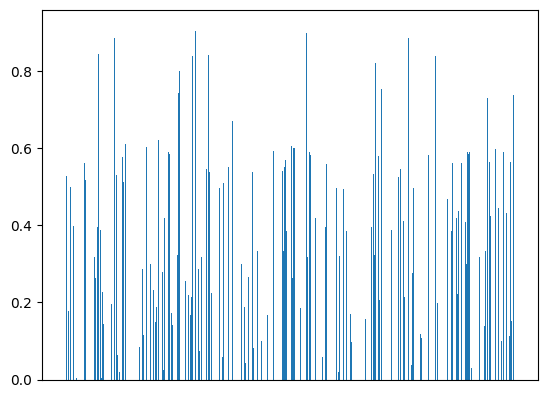

<function mean at 0x000001DFD0174680>


In [167]:
# fraction of the days are missing for each column
missing = np.isnan(stock_data).sum()/len(stock_data)
plt.bar(missing.index, missing)
plt.xticks([]) # Remove x-axis label for better layout
plt.show()
print(np.mean)

**Step 2: Identify highly correlated pairs**

###### We first look at the returns correlation across entire time-series and select those with correlation > 0.8

In [267]:
# calculate returns 
returns_data = np.log(stock_data/stock_data.shift(1))

# calculate the correlation matrix
correlation_matrix = returns_data.corr()

# select pairs with high correlation
high_corr_pairs = []
threshold = 0.8

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], 
                                    correlation_matrix.columns[j]))

d:\OneDrive - University of Southampton\Documents\Official\Applications\2024\Bluecrest\bluecrest\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


###### Then test for cointegration on high correlation pairs

In [270]:
def cointegration_test(stock_data, stock1, stock2):
    clean_data = pd.concat([stock_data[stock1], 
                            stock_data[stock2]], axis=1).dropna()
    model = sm.OLS(clean_data[stock1], sm.add_constant(clean_data[stock2]))
    result = model.fit()
    return sm.tsa.adfuller(result.resid)

cointegrated_pairs = []

for pair in high_corr_pairs:
    p_value = cointegration_test(stock_data, pair[0], pair[1])[1]
    if p_value < 0.05:  # Using 5% significance level
        cointegrated_pairs.append(pair)


###### Calculate z-score of the spread over time and plot

In [271]:
# calculate the spread and z-score
def calculate_zscore(spread):
    return (spread - spread.mean()) / spread.std()

In [274]:
def plot_spreads_in_zscores(stock_data, cointegrated_pairs):
    """
    Plots the spread in z-scores for each pair in cointegrated_pairs.

    Parameters:
    - stock_data: DataFrame containing stock price data for multiple stocks.
    - cointegrated_pairs: List of tuples containing pairs of stock tickers.

    Returns:
    - Displays a grid of plots showing the spread in z-scores for each pair.
    """

    num_pairs = len(cointegrated_pairs)
    cols = 2  # Fixed number of columns
    rows = (num_pairs // cols) + (num_pairs % cols > 0)  # Calculate the required number of rows

    fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 3))  # Adjust figsize based on the number of rows

    # Flatten axes array if there is only one row or column
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)
    if cols == 1:
        axes = np.expand_dims(axes, axis=1)

    index = 0
    for i in range(rows):
        for j in range(cols):
            if index >= num_pairs:
                axes[i, j].axis('off')  # Hide any unused subplots
                continue

            stock1, stock2 = cointegrated_pairs[index]
            spread = stock_data[stock1] - stock_data[stock2]
            zscore = calculate_zscore(spread)

            ax = axes[i, j]
            ax.plot(zscore)
            ax.axhline(2.0, color='red', linestyle='--')
            ax.axhline(-2.0, color='red', linestyle='--')
            ax.axhline(0, color='black', linestyle='-')
            ax.set_title(f"{stock1} - {stock2}")
            ax.set_xticks([])  # Remove x-axis ticks for better layout

            index += 1

    # Adjust layout and display the plot
    fig.suptitle("Spread (in z-scores) evolution of Cointegrated Pairs", fontsize=14)
    plt.tight_layout()
    plt.show()

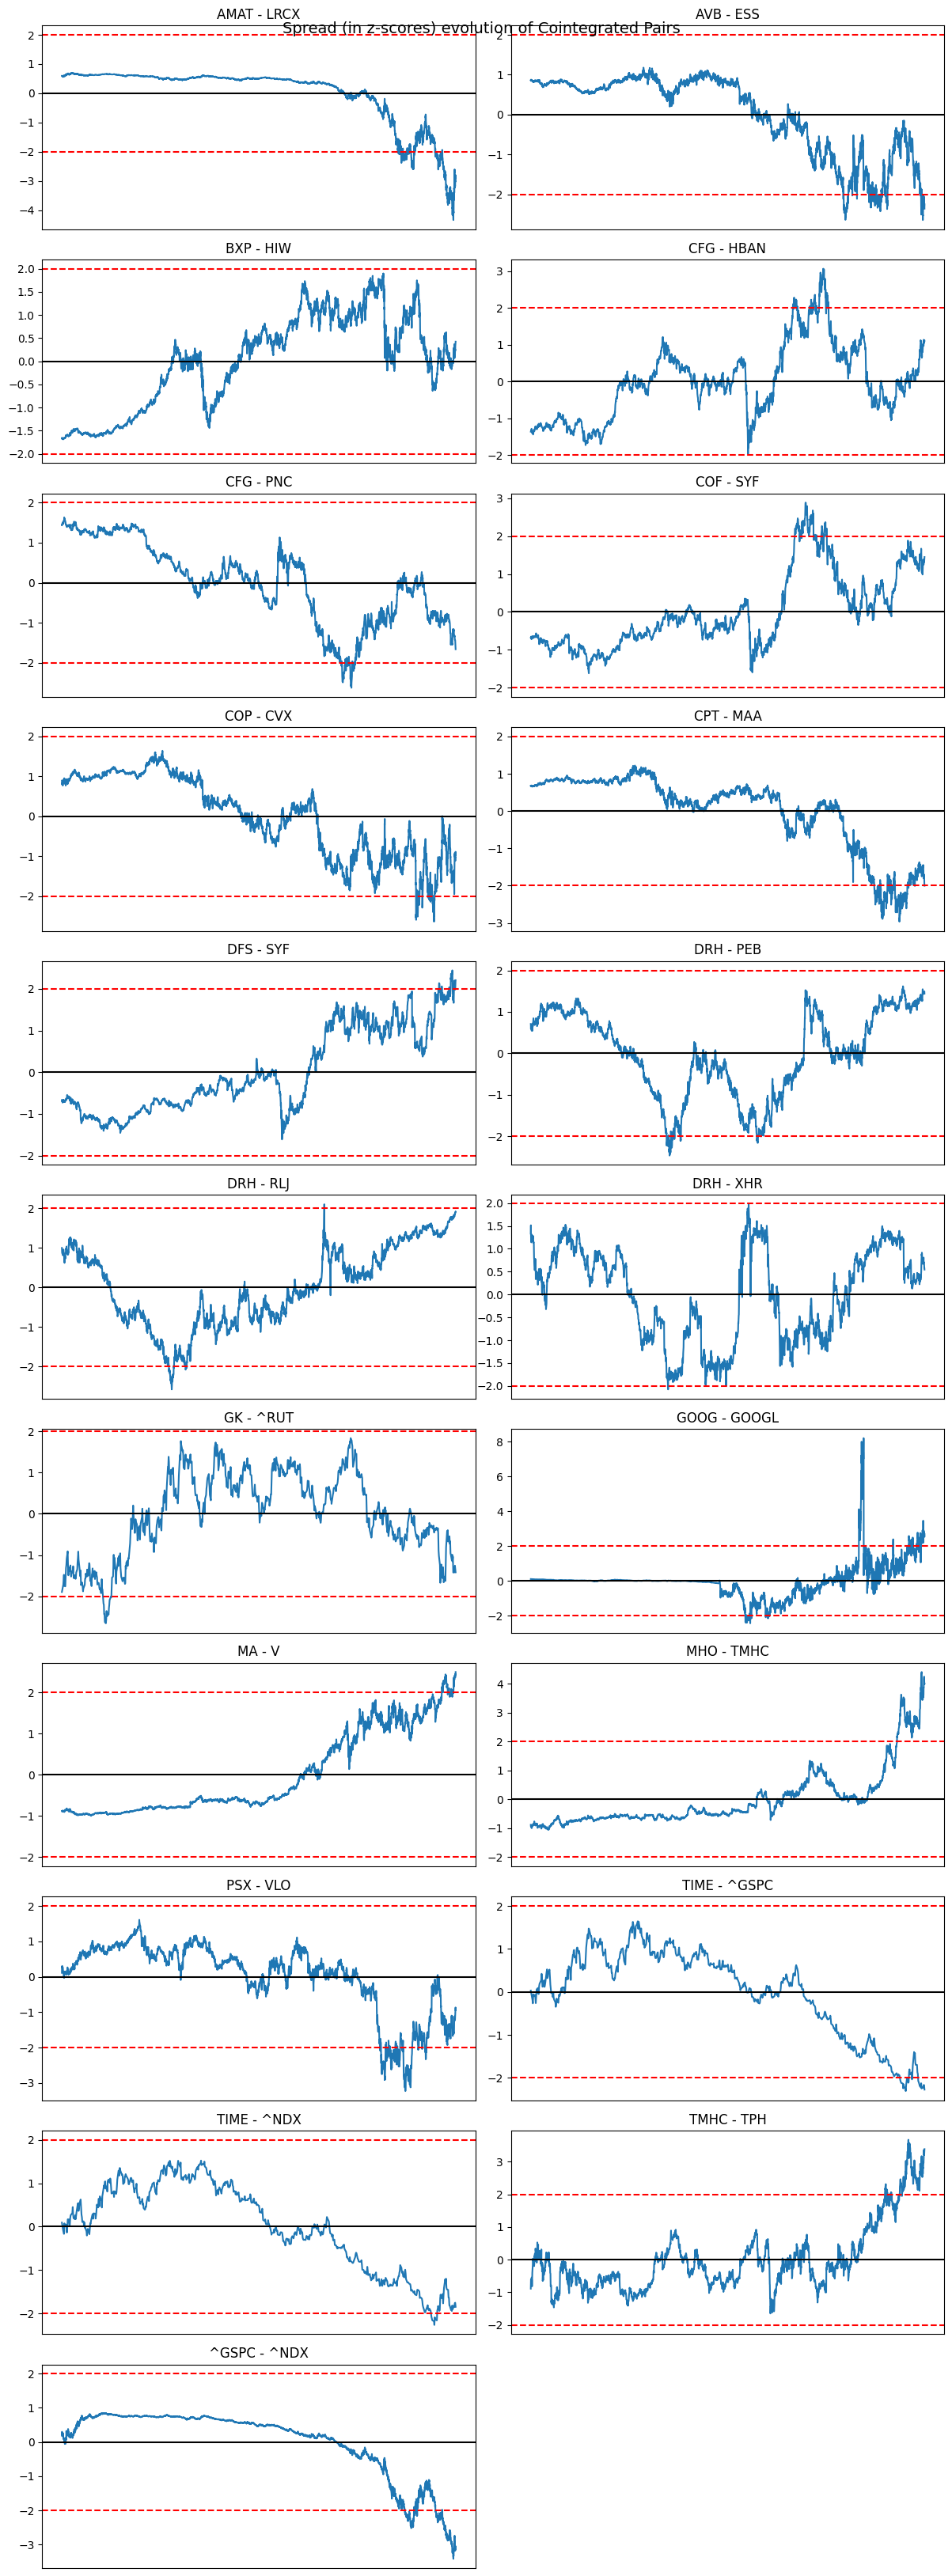

In [275]:
plot_spreads_in_zscores(stock_data, cointegrated_pairs)

###### The currenet methodology that looks at the full time series to search for a well-behaved pair that has been constantly mean-reverting over the past 24 years. Clearly, this is not realisic.

###### Therefore, we now take into consideration the recentness and the consistency of the strategy, by looking at the rolling correlation.

###### Note that this search is very expensive for a home PC due to the size of the asset space, therefore only ~5% of the available assets are searched in our example. However, the same code could be run in parallel in a more powerful PC to search the entire space.

###### Function to calculate pairwise rolling correlation

In [159]:
def calculate_pairwise_rolling_correlation(stock_data, window=252):
    """
    Calculate the rolling pairwise correlation for each pair of stocks in the 
    DataFrame.
    
    Parameters:
    - stock_data: A pandas DataFrame where each column represents a stock's 
                  time-series data.
    - window: The rolling window size for calculating correlations.
    
    Returns:
    - A dictionary where each key is a tuple representing a stock pair, 
      and the value is the rolling correlation series.
    """
    results = {}

    # Loop through all unique pairs of stocks in the DataFrame
    for stock_A, stock_B in combinations(stock_data.columns, 2):
        # Calculate rolling correlation between the two stocks
        rolling_corr = stock_data[stock_A].rolling(window=window).corr(stock_data[stock_B])
        
        # Store the rolling correlation series in the results dictionary
        results[(stock_A, stock_B)] = rolling_corr
    
    return results

###### Function to calculate exponentially weighted moving average

In [160]:
def apply_ema(series, span):
    """
    Apply Exponentially Weighted Moving Average (EMA) to a series.
    
    Parameters:
    - series: The pandas Series to which EMA will be applied.
    - span: The span parameter for the EMA.
    
    Returns:
    - A pandas Series with the EMA applied.
    """
    return series.ewm(span=span, adjust=False).mean()

###### Function apply Kalman Filter

In [255]:
def apply_kalman_filter(series):
    """
    Apply Kalman Filter to a time series using the filterpy library.
    
    Parameters:
    - series: The pandas Series to which Kalman Filter will be applied.
    
    Returns:
    - A pandas Series with the Kalman Filter applied.
    """
    
    # Drop all missing data - this should have been cleaned out beforehand
    series = series.dropna()
    
    # Initialize KalmanFilter object
    kf = KalmanFilter(dim_x=1, dim_z=1)
    
    # Define initial state (just the first observation, no velocity)
    kf.x = np.array([[series.iloc[0]]])
    
    # Define the state transition matrix (identity matrix for no change in state)
    kf.F = np.array([[1]])
    
    # Define the measurement function (identity matrix)
    kf.H = np.array([[1]])
    
    # Define the initial covariance matrix for the state (initial uncertainty)
    kf.P *= 10.0  # Start with high initial uncertainty
    
    # Define the measurement noise (covariance of measurement errors)
    kf.R = 0.05  # Measurement noise, relatively small for correlation values
    
    # Define the process noise covariance (how much we expect the state to change)
    kf.Q = np.array([[0.05]])  # Small process noise for smooth changes
    
    # Storage for the filtered results
    filtered_state_means = []

    for measurement in series:
        kf.predict()
        kf.update(measurement)
        filtered_state_means.append(kf.x[0, 0])

    return pd.Series(filtered_state_means, index=series.index)

###### Filter for pairs with high levels of correlation based on parameter/method of choice

In [256]:
def filter_high_correlation_pairs(results, threshold=0.8, method='last', smoothing_param=None):
    """
    Filter out stock pairs with high correlations using different methods.
    
    Parameters:
    - results: A dictionary where each key is a tuple representing a stock pair, and the value is the rolling correlation series.
    - threshold: The correlation threshold above which pairs are considered highly correlated.
    - method: The method to use ('last', 'ema', 'kalman').
    - smoothing_param: The parameter for the smoothing method (e.g., span for EMA).
    
    Returns:
    - A list of stock pairs that have had high correlations.
    """
    filtered_pairs = []

    for pair, rolling_corr in results.items():
        # Apply the chosen method
        if method == 'ema':
            if smoothing_param is None:
                smoothing_param = 63  # Default span is a month if not provided
            smoothed_corr = apply_ema(rolling_corr.dropna(), span=smoothing_param)
        elif method == 'kalman':
            smoothed_corr = apply_kalman_filter(rolling_corr.dropna())
        elif method == 'last':
            smoothed_corr = rolling_corr.dropna()
        else:
            raise ValueError(f"Unknown method: {method}")

        # Check if the correlation is above the threshold

        if smoothed_corr.dropna().iloc[-1] > threshold:
            filtered_pairs.append(pair)

    return filtered_pairs

In [257]:
def plot_correlation_results(results, filtered_pairs, rows=3, cols=3, ema_span=30):
    """
    Plot a grid of line charts showing the rolling correlations for the selected pairs,
    including EMA and Kalman smoothed lines.

    Parameters:
    - results: A dictionary where each key is a tuple representing a stock pair, and the value is the rolling correlation series.
    - filtered_pairs: A list of stock pairs that were filtered based on high recent correlations.
    - rows: Number of rows in the plot grid.
    - cols: Number of columns in the plot grid.
    - ema_span: The span for EMA smoothing.

    Returns:
    - A plot displaying the rolling correlations, EMA, and Kalman smoothed lines for the filtered stock pairs.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
    axes = axes.flatten()

    # Plot only the top (rows * cols) pairs
    for i, pair in enumerate(filtered_pairs[:rows * cols]):
        if pair in results:
            rolling_corr = results[pair].dropna()

            # Apply smoothing
            ema_smoothed = apply_ema(rolling_corr, span=ema_span)
            kalman_smoothed = apply_kalman_filter(rolling_corr)

            # Plot original rolling correlation
            axes[i].plot(rolling_corr, label='Rolling Correlation', color='black', alpha=0.5)
            
            # Plot EMA smoothed
            axes[i].plot(ema_smoothed, label=f'EMA (span={ema_span})', color='hotpink', alpha=0.5)
            
            # Plot Kalman smoothed
            axes[i].plot(kalman_smoothed, label='Kalman Smoothed', color='cyan', alpha=0.5)

            # Set titles and labels
            axes[i].set_title(f'{pair[0]} vs {pair[1]}')
            axes[i].set_xlabel('Date')
            axes[i].set_ylabel('Correlation')
            axes[i].legend()
            axes[i].grid(True)

    # Hide any remaining empty subplots
    for i in range(len(filtered_pairs), rows * cols):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [258]:
def plot_correlation_results(results, filtered_pairs, ema_span=30):
    """
    Plot a grid of line charts showing the rolling correlations for the selected pairs,
    including EMA and Kalman smoothed lines.

    Parameters:
    - results: A dictionary where each key is a tuple representing a stock pair, and the value is the rolling correlation series.
    - filtered_pairs: A list of stock pairs that were filtered based on high recent correlations.
    - ema_span: The span for EMA smoothing.

    Returns:
    - A plot displaying the rolling correlations, EMA, and Kalman smoothed lines for the filtered stock pairs.
    """
    # Set the number of columns
    cols = 2
    # Dynamically calculate the number of rows needed
    rows = math.ceil(len(filtered_pairs) / cols)

    # Initialize the plot with the calculated dimensions
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
    axes = axes.flatten()

    # Plot each pair
    for i, pair in enumerate(filtered_pairs):
        if pair in results:
            rolling_corr = results[pair].dropna()

            # Apply smoothing
            ema_smoothed = apply_ema(rolling_corr, span=ema_span)
            kalman_smoothed = apply_kalman_filter(rolling_corr)

            # Plot original rolling correlation
            axes[i].plot(rolling_corr, label='Rolling Correlation', color='black', alpha=0.5)
            
            # Plot EMA smoothed
            axes[i].plot(ema_smoothed, label=f'EMA (span={ema_span})', color='hotpink', alpha=0.5)
            
            # Plot Kalman smoothed
            axes[i].plot(kalman_smoothed, label='Kalman Smoothed', color='cyan', alpha=0.5)

            # Set titles and labels
            axes[i].set_title(f'{pair[0]} vs {pair[1]}')
            axes[i].set_xlabel('Date')
            axes[i].set_ylabel('Correlation')
            axes[i].legend()
            axes[i].grid(True)

    # Hide any remaining empty subplots
    for i in range(len(filtered_pairs), rows * cols):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [259]:
# Restrict stock universe to save computational cost
test_data = stock_data.iloc[-1010:-252, -100:]

# Restrict stock universe to save computational cost
train_data = stock_data.iloc[-252:, -100:]

In [260]:
# Calculate rolling correlation
results = calculate_pairwise_rolling_correlation(test_data.diff(), window=63)

In [261]:
# Smooth
filtered_pairs_last = filter_high_correlation_pairs(results, threshold=0.8, method='last')
filtered_pairs_ema = filter_high_correlation_pairs(results, threshold=0.8, method='ema', smoothing_param=63)
filtered_pairs_kalman = filter_high_correlation_pairs(results, threshold=0.8, method='kalman')

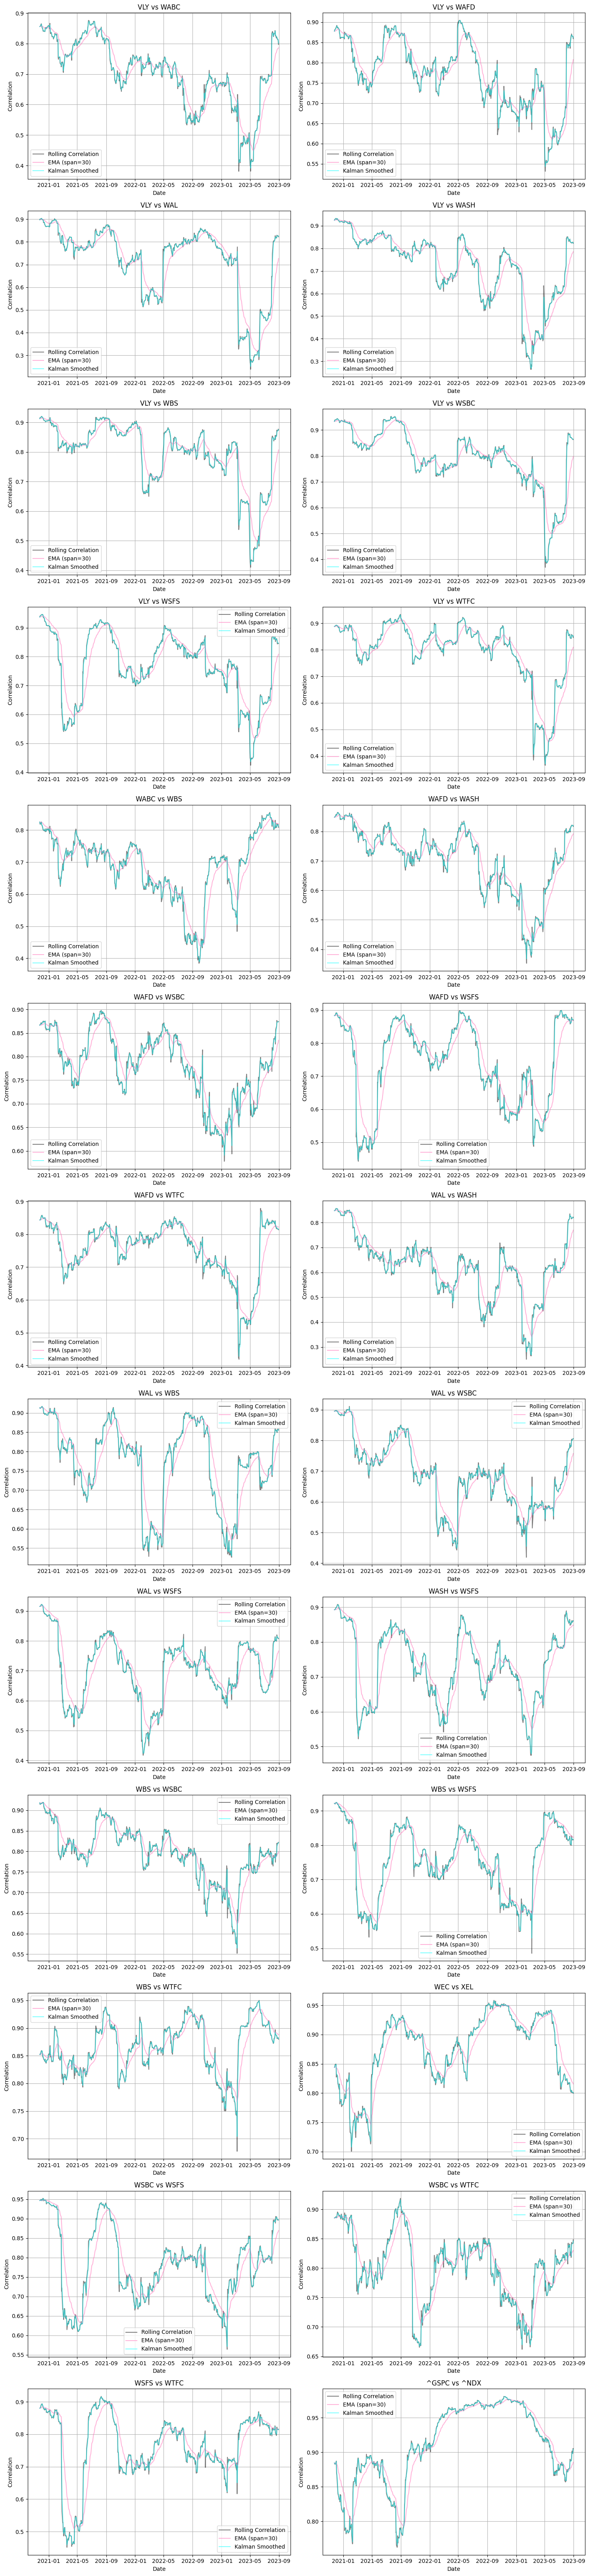

In [263]:
# plot the various smoothing methods
plot_correlation_results(results, filtered_pairs_kalman)

3. Given the list of correlated pairs from the recent step, backtest a mean reverting trading strategy based on various entry/exit conditions, trade duration, or any other relevant parameters.

###### Creat backtester, where mean-reversion window and entry/exit/stoploss thresholds in z-score terms can be specified

In [241]:
def backtest_pairs_trading(stock_data, pairs, window=21, entry_threshold=2.0, 
                           exit_threshold=0.0, stoploss_threshold=3.0):
    """
    Backtest a pairs trading strategy for mean reversion with stop-loss.

    Parameters:
    - stock_data: DataFrame with historical price data for all stocks.
    - pairs: Either a single tuple containing a stock pair (e.g., ('AAPL', 'MSFT')),
             or a list of tuples containing stock pairs (e.g., [('AAPL', 'MSFT'), ...]).
    - window: Rolling window size for z-score calculation.
    - entry_threshold: Z-score threshold for entering a trade.
    - exit_threshold: Z-score threshold for exiting a trade.
    - stoploss_threshold: Z-score threshold for stop-loss.

    Returns:
    - A DataFrame with the strategy's performance metrics.
    """
    # Ensure pairs is a list, even if a single pair is provided
    if isinstance(pairs, tuple):
        pairs = [pairs]
    
    results = {}
    plot_count = len(pairs)
    cols = 2  # Maximum number of charts per row
    rows = (plot_count + cols - 1) // cols  # Calculate the number of rows needed

    # Initialize plots for spreads
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
    axes = axes.flatten()
    
    # Initialize plots for position
    position_fig, position_axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
    position_axes = position_axes.flatten()

    # Initialize plots for cumulative P&L
    pnl_fig, pnl_axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
    pnl_axes = pnl_axes.flatten()

    for idx, (stock_A, stock_B) in enumerate(pairs):
        if stock_A not in stock_data.columns or stock_B not in stock_data.columns:
            continue

        # Get price data
        prices_A = stock_data[stock_A]
        prices_B = stock_data[stock_B]

        # Calculate spread
        spread = prices_A - prices_B

        # Calculate rolling mean and std deviation
        rolling_mean = spread.rolling(window=window).mean()
        rolling_std = spread.rolling(window=window).std()

        # Convert Z-score thresholds to spread values
        entry_spread_threshold_high = rolling_mean + entry_threshold * rolling_std
        entry_spread_threshold_low = rolling_mean - entry_threshold * rolling_std
        exit_spread_threshold = rolling_mean
        stoploss_spread_threshold_high = rolling_mean + stoploss_threshold * rolling_std
        stoploss_spread_threshold_low = rolling_mean - stoploss_threshold * rolling_std

        # Calculate z-score
        z_scores = (spread - rolling_mean) / rolling_std

        # Initialize positions and P&L
        position = pd.Series(0, index=stock_data.index, dtype=float)
        
        # Dummy variable to indicate whether the strategy can enter a position 
        dummy = True

        # Variable indicating whether the strategy is currently long/short
        long = True
        
        for i in range(1, len(z_scores)):
            if dummy:
                if z_scores.iloc[i] < -entry_threshold:
                    position.iloc[i] = 1  # Long position
                    long = True
                    dummy = False
                elif z_scores.iloc[i] > entry_threshold:
                    position.iloc[i] = -1  # Short position
                    long = False
                    dummy = False
            else:
                if np.abs(z_scores.iloc[i]) > stoploss_threshold:
                    position.iloc[i] = 0  # Exit position
                    dummy = True
                elif z_scores.iloc[i] > exit_threshold and long:
                    position.iloc[i] = 0  # Exit position
                    dummy = True
                elif z_scores.iloc[i] < exit_threshold and not long:
                    position.iloc[i] = 0  # Exit position
                    dummy = True
                else:
                    position.iloc[i] = position.iloc[i-1]  # Hold the previous position

        # Calculate returns
        returns = stock_data[stock_A].pct_change() - stock_data[stock_B].pct_change()
        strategy_returns = position.shift(1) * returns

        # Calculate cumulative P&L
        cumulative_pnl = strategy_returns.cumsum()

        # Calculate performance metrics
        total_return = cumulative_pnl.iloc[-1]
        annualized_return = (1 + strategy_returns.mean()) ** 252 - 1
        annualized_volatility = strategy_returns.std() * np.sqrt(252)
        sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

        # Store results
        results[(stock_A, stock_B)] = {
            'Total Return': total_return,
            'Annualized Return': annualized_return,
            'Annualized Volatility': annualized_volatility,
            'Sharpe Ratio': sharpe_ratio
        }

        # Plot Spread (instead of Z-Score)
        if idx < len(axes):
            axes[idx].plot(spread, label=f'{stock_A} vs {stock_B} Spread', color='navy', alpha=.7)
            axes[idx].plot(entry_spread_threshold_high, color='hotpink', linestyle='--', label='Entry Threshold', alpha=.7)
            axes[idx].plot(entry_spread_threshold_low, color='hotpink', linestyle='--', alpha=.7)
            axes[idx].plot(exit_spread_threshold, color='cyan', linestyle='--', label='Exit Threshold', alpha=.7)
            axes[idx].plot(stoploss_spread_threshold_high, color='red', linestyle='--', label='Stop-Loss Threshold', alpha=.7)
            axes[idx].plot(stoploss_spread_threshold_low, color='red', linestyle='--', alpha=.7)
            axes[idx].set_title(f'{stock_A} vs {stock_B}')
            axes[idx].set_xlabel('Date')
            axes[idx].set_ylabel('Spread')
            axes[idx].legend()

            # Reduce the frequency of x-axis labels
            axes[idx].xaxis.set_major_locator(plt.MaxNLocator(5))  # Display at most 5 x-axis labels

        # Plot position
        if idx < len(position_axes):
            position_axes[idx].plot(position, label=f'{stock_A} vs {stock_B} Position', color='mediumpurple')
            position_axes[idx].set_title(f'{stock_A} vs {stock_B}')
            position_axes[idx].set_xlabel('Date')
            position_axes[idx].set_ylabel('Current exposure')

            # Reduce the frequency of x-axis labels
            position_axes[idx].xaxis.set_major_locator(plt.MaxNLocator(5))  # Display at most 5 x-axis labels

        # Plot P&L
        if idx < len(pnl_axes):
            pnl_axes[idx].plot(cumulative_pnl, label=f'{stock_A} vs {stock_B} P&L', color='cyan')
            pnl_axes[idx].set_title(f'{stock_A} vs {stock_B}')
            pnl_axes[idx].set_xlabel('Date')
            pnl_axes[idx].set_ylabel('Cumulative P&L')

            # Reduce the frequency of x-axis labels
            pnl_axes[idx].xaxis.set_major_locator(plt.MaxNLocator(5))  # Display at most 5 x-axis labels

    # Hide any unused subplots
    for i in range(len(pairs), len(axes)):
        axes[i].axis('off')
        pnl_axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(results).T


###### Run backtester on the highly correlated pairs identified earlier

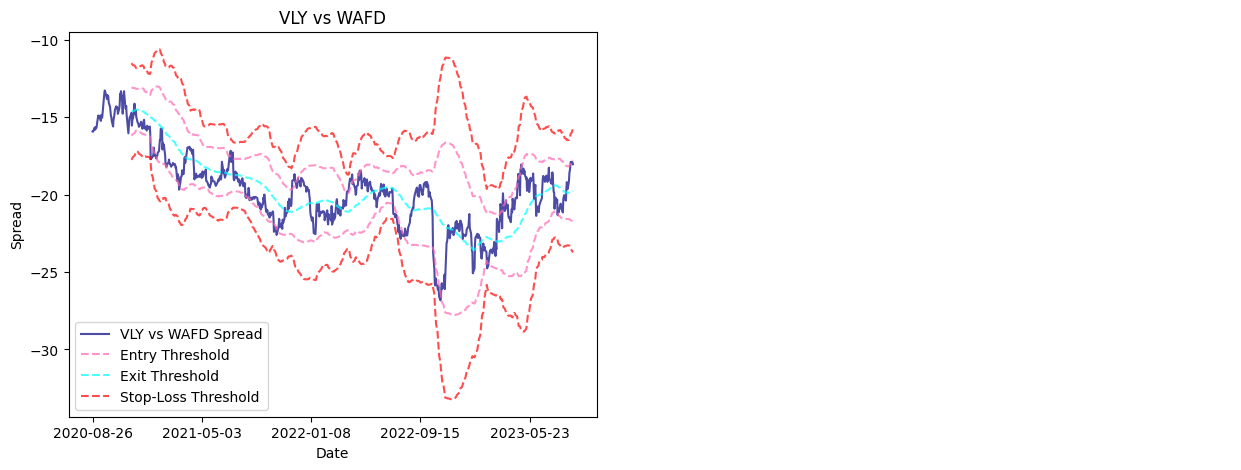

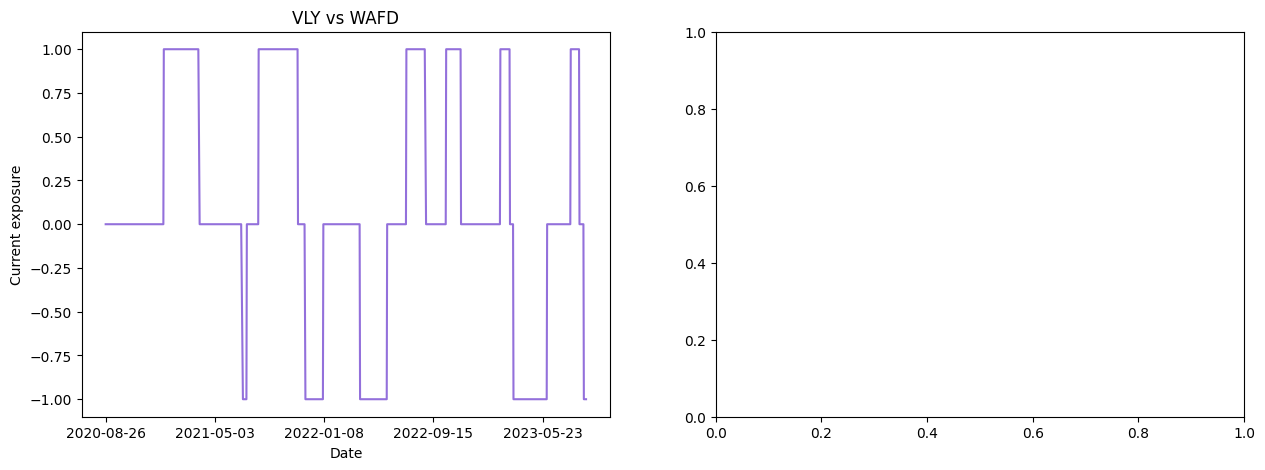

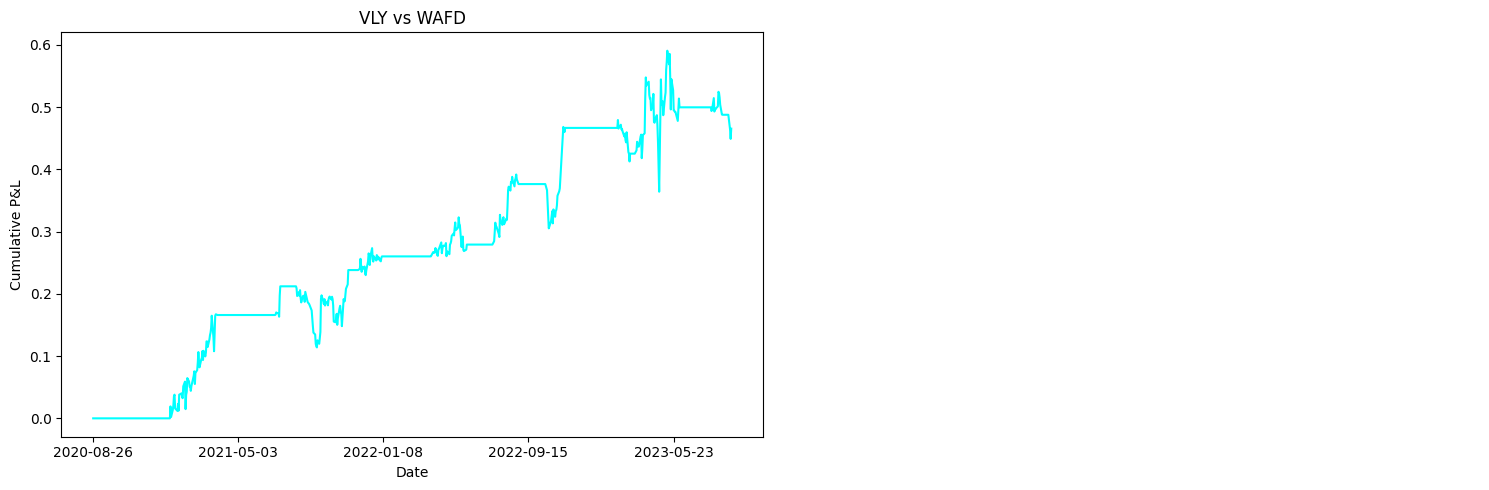

In [242]:
performance = backtest_pairs_trading(test_data, filtered_pairs_last[0], window=63, entry_threshold=2.0, exit_threshold=0.0, stoploss_threshold=4.0)


In [238]:
filtered_pairs_last[0]

('VLY', 'WAFD')